This notebook aims to build ML models for user recognition based on their keystroke data. Here are some key points to note:

*   Keystroke dynamics is a behavioural biometric that utilizes a 
person's typing pattern to verify their identity.
*   The typing patterns are mainly extracted from computer keyboards and are derived from the Key-Press and Key-Release events that make up a keystroke.
*   The Key-Press event happens when a key is initially depressed, while the Key-Release event occurs when the key is subsequently released.

In [ ]:
!pip install xgboost==1.2.1

Import the necessary modules.

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle

### Be sure to use xgboost version 1.2.1

In [ ]:
print(xgb.__version__)

### Importing the Dataset

This dataset contains keystroke data from 110 users. Each user was asked to type a 13-character constant string 8 times, and the keystroke data (key-press time and key-release time for each key) were collected. 

*   The dataset contains 880 rows and 27 columns. 
*   The first column represents the UserID, and the rest of the columns show the press and release time for the first to 13th character.

In [3]:
# Load and view the train data
train_data = pd.read_csv('Train_keystroke.csv')
train_data.head()

,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,1,0,120,216,312,424,496,592,664,808,...,1712,1760,1992,2064,2376,2448,2584,2632,2752,2824
1,1,0,95,168,265,360,455,527,599,736,...,1423,1471,1664,1711,1880,1952,2039,2111,2231,2279
2,1,0,71,143,231,783,903,1087,1159,1351,...,2039,2111,2271,2343,2487,2559,2679,2751,2871,2926
3,1,0,95,144,263,353,431,760,832,1159,...,3151,3223,3415,3463,3631,3703,3815,3887,3983,4055
4,1,0,70,166,238,310,406,526,598,710,...,1310,1382,1543,1605,1734,1806,1926,1998,2086,2182


In [5]:
len(train_data.columns)

27

### Feature Extraction

4 features (Hold Time “HT”, Press-Press time “PPT”, Release-Release Time “RRT”, Release-Press time “RPT”) are introduced and defined as described in the figure below.

8 features was generated from the dataset. 

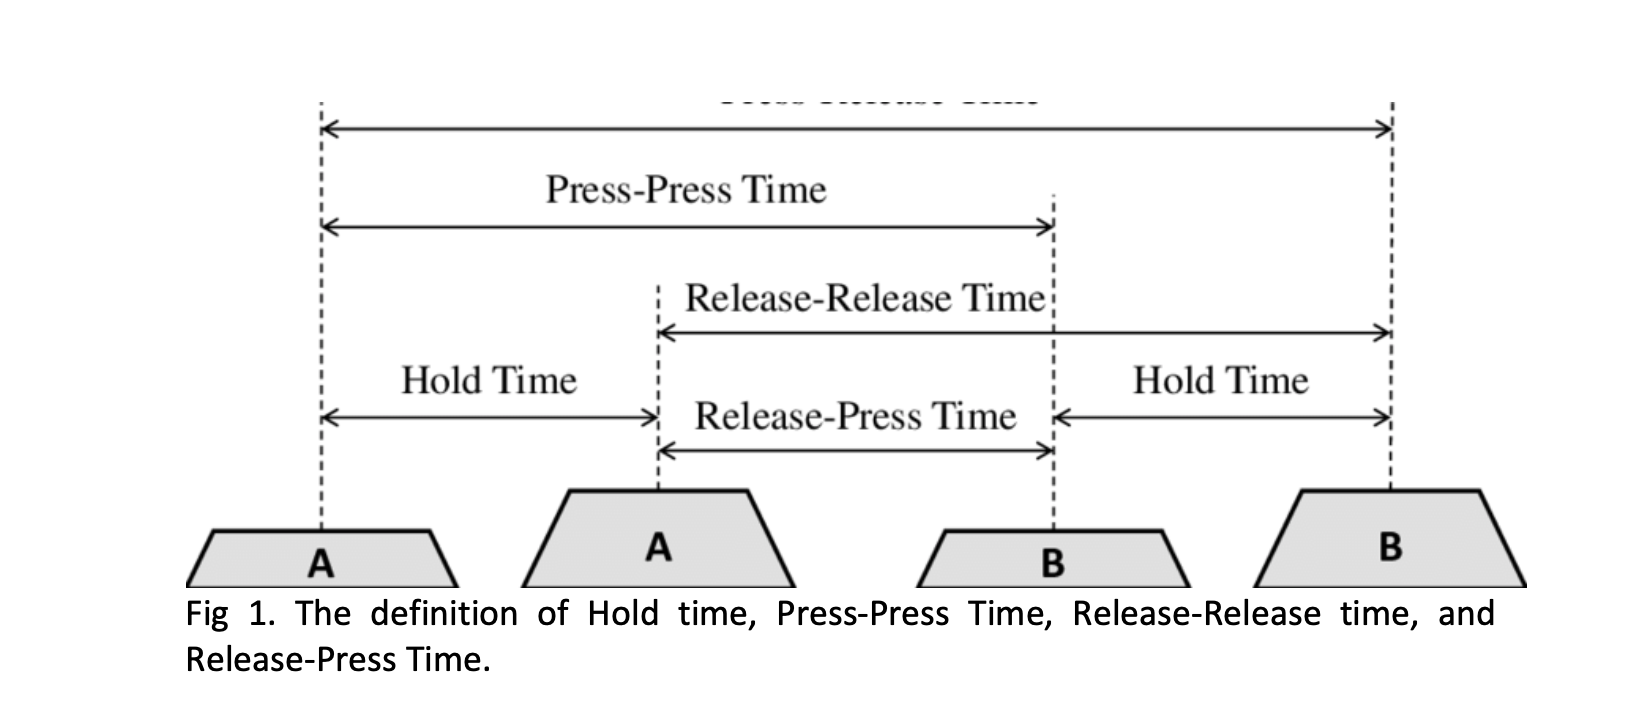

I defined a function called calculate_features, which takes the training data as input and calculates four features from it, namely hold_time, press_press, release_release, and release_press. 

The features are then converted to NumPy arrays and returned.



In [1]:

# Define a function to calculate the 4 features
def calculate_features(df):
    # Initialize lists to store the features
    hold_time = []
    press_press = []
    release_release = []
    release_press = []

    # Loop through each row of the dataframe
    for i in range(df.shape[0]):
        row = df.iloc[i, 1:]
        press = row[::2]
        release = row[1::2]

        # Calculate the 4 features for each row
        ht = [release[j] - press[j] for j in range(len(press))]
        pp = [press[j+1] - press[j] for j in range(len(press) - 1)]
        rr = [release[j+1] - release[j] for j in range(len(release) - 1)]
        rp = [press[j+1] - release[j] for j in range(len(release) - 1)]

        # Append the features to the respective lists
        hold_time.append(ht)
        press_press.append(pp)
        release_release.append(rr)
        release_press.append(rp)

    # Convert the lists to a numpy array
    hold_time = np.array(hold_time)
    press_press = np.array(press_press)
    release_release = np.array(release_release)
    release_press = np.array(release_press)

    return hold_time, press_press, release_release, release_press


In [ ]:
# Call the function to calculate the 4 features
hold_time, press_press, release_release, release_press = calculate_features(train_data)

In [ ]:
# Calculate the mean and standard deviation of each feature
hold_time_mean = np.mean(hold_time, axis=1)
hold_time_std = np.std(hold_time, axis=1)
press_press_mean = np.mean(press_press, axis=1)
press_press_std = np.std(press_press, axis=1)
release_release_mean = np.mean(release_release, axis=1)
release_release_std = np.std(release_release, axis=1)
release_press_mean = np.mean(release_press, axis=1)
release_press_std = np.std(release_press, axis=1)

# Concatenate the mean and standard deviation of each feature into a single array
features = np.column_stack((hold_time_mean, hold_time_std, 
                            press_press_mean, press_press_std, 
                            release_release_mean, release_release_std, 
                            release_press_mean, release_press_std))

# Add the UserID to the features array
user_ids = train_data.iloc[:, 0]
features = np.column_stack((user_ids, features))

In [ ]:
# Save the features to a pandas dataframe
features_df = pd.DataFrame(features, columns=["UserID", "HoldTimeMean", 
                                              "HoldTimeStd", "PressPressMean", 
                                              "PressPressStd", "ReleaseReleaseMean", 
                                              "ReleaseReleaseStd", "ReleasePressMean", 
                                              "ReleasePressStd"])

# Print the head of the dataframe
features_df.head()

,UserID,HoldTimeMean,HoldTimeStd,PressPressMean,PressPressStd,ReleaseReleaseMean,ReleaseReleaseStd,ReleasePressMean,ReleasePressStd
0,1.0,72.000000,21.049392,229.333333,60.428102,225.333333,69.958718,157.333333,65.019655
1,1.0,70.384615,16.836492,185.916667,34.862727,182.000000,38.464269,113.666667,44.548351
2,1.0,80.307692,16.498879,239.250000,130.555943,237.916667,139.135700,156.833333,127.846805
3,1.0,72.000000,20.373437,331.916667,352.649604,330.000000,338.389568,259.916667,347.130249
4,1.0,74.769231,13.325244,173.833333,45.487788,176.000000,38.177218,100.833333,45.586609


In [ ]:
# Split the data into input features X and target labels y
X = features_df.iloc[:, 1:].values
y = features_df.iloc[:, 0].values

# Train a SVM model
svm_model = SVC()
svm_model.fit(X, y)

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Save the SVM model using pickle
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

# Save the RandomForestClassifier model using pickle
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Save the XGBClassifier model using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)